### Multidimensional outlier detection

In [ ]:
"""
Shared data
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import MinCovDet
from scipy.spatial.distance import mahalanobis

## make some toy data
size = 200
feature_1 = np.random.normal(loc = 5., scale = 2., size = size)
feature_2 = np.random.normal(loc = 10., scale = 1., size = size)
feature_3 = np.random.normal(loc = 1., scale = 0.1, size = size)
data = np.stack((feature_1, feature_2, feature_3))
data = np.swapaxes(data, 0,1)

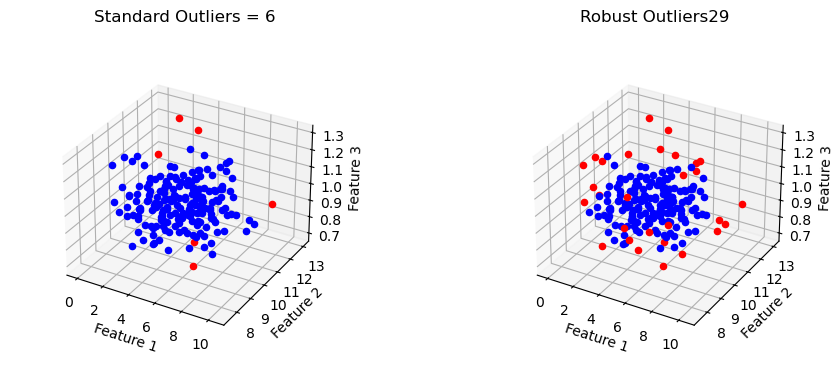

In [68]:
"""
MAHALANOBIS DISTANCE

The 'standard' version of M. distance uses mean and covariance of ALL
data during computation, which is inherently affected by outliers in
the data. A robust version of the M. distance uses the median and the
Minimum Covariance Determinant (MCD) during distance computation, making
the results more robust against outliers and thus more effective at 
finding the outliers. Note there is the assumption of Gaussian data
distributions for M. distance

To determine if a point is an outlier, we'll check if it lies outside 
3 standard deviations in the multidimensional space. For teh Standard
computation, we'll just use the STD from the input data. For the Robust
outlier detection, we'll find 75% of the data with the smallest robust
M. distances, and calculate STD based on those points.

The results show that using Robust methods flags more points as
potential outliers that warrant further investogation
"""



## get the mean and median
data_mean = np.mean(data, axis=0)
data_median = np.median(data, axis=0)

## calculate covariance matrices
cov = np.cov(np.swapaxes(data, 0,1))
mcd =  MinCovDet().fit(data)

## calculate inverse matrices
inv_cov = np.linalg.matrix_power(cov, -1)
inv_mcd = np.linalg.matrix_power(mcd.covariance_, -1)

## calculate the standard and robust mahalanobis distances
standard_maha = [mahalanobis(i, data_mean, inv_cov) for i in data]
robust_maha = [mahalanobis(i, data_median, inv_mcd) for i in data]

## determine if points are outliers
def is_outlier(x, y, z, i, j, k, s1, s2, s3, thresh=3):
    """
    x,y,z are values for current point
    i,j,k are the origin values
    s1,s2,s3 are the STD's for each dimension
    thresh is the STD multiplier to determine if point is outlier
    """
    if (x-i)**2/(thresh*s1)**2 + (y-j)**2/(thresh*s2)**2 + (z-k)**2/(thresh*s3)**2 <= 1:
        return False
    else:
        return True

std_f1 = np.std(feature_1)  # standard deviations of input data
std_f2 = np.std(feature_2)
std_f3 = np.std(feature_3)

min_idxs = np.where(robust_maha < np.percentile(robust_maha, 75))[0] # get 75% closest points
mstd_f1 = np.std(feature_1[min_idxs])  # standard deviation just from closest points
mstd_f2 = np.std(feature_2[min_idxs])
mstd_f3 = np.std(feature_3[min_idxs])


standard_outliers = []
robust_outliers = []
for d in range(data.shape[0]):
    standard_outliers.append(is_outlier(data[d,0], data[d,1], data[d,2],
                                        data_mean[0], data_mean[1], data_mean[2],
                                        std_f1, std_f2, std_f3))

    robust_outliers.append(is_outlier(data[d,0], data[d,1], data[d,2],
                                        data_median[0], data_median[1], data_median[2],
                                        mstd_f1, mstd_f2, mstd_f3))


## 3d scatterplot
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1,2,1,projection='3d')
for i in range(data.shape[0]):
    if standard_outliers[i]:
        ax1.scatter(data[i,0], data[i,1], data[i,2], c="red")
    else:
        ax1.scatter(data[i,0], data[i,1], data[i,2], c="blue")
ax1.set(xlabel="Feature 1",
      ylabel="Feature 2",
      zlabel="Feature 3",
      title="Standard Outliers = "+str(np.array(standard_outliers).sum()))
ax1.set_box_aspect(aspect=None, zoom=0.8)

ax2 = fig.add_subplot(1,2,2,projection='3d')
for i in range(data.shape[0]):
    if robust_outliers[i]:
        ax2.scatter(data[i,0], data[i,1], data[i,2], c="red")
    else:
        ax2.scatter(data[i,0], data[i,1], data[i,2], c="blue")
ax2.set(xlabel="Feature 1",
      ylabel="Feature 2",
      zlabel="Feature 3",
      title="Robust Outliers"+str(np.array(robust_outliers).sum()))
ax2.set_box_aspect(aspect=None, zoom=0.8)

plt.tight_layout()
plt.show()